In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os

#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

print("Path to dataset files:", path)

100%|██████████| 140M/140M [00:07<00:00, 19.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/swaroopkml/cifar10-pngs-in-folders/versions/1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()  # Subir kaggle.json

import os
import zipfile

os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
os.chmod("/root/.kaggle/kaggle.json", 600)

!kaggle datasets download -d swaroopkml/cifar10-pngs-in-folders
with zipfile.ZipFile("cifar10-pngs-in-folders.zip", "r") as zip_ref:
    zip_ref.extractall("cifar10_dataset")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/swaroopkml/cifar10-pngs-in-folders
License(s): unknown
 91% 128M/140M [00:00<00:00, 1.33GB/s]
100% 140M/140M [00:00<00:00, 1.33GB/s]


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Dispositivo: GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformación para las imágenes
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar datasets desde carpetas
train_dataset = datasets.ImageFolder(root="cifar10_dataset/cifar10/cifar10/train", transform=transform)
test_dataset = datasets.ImageFolder(root="cifar10_dataset/cifar10/cifar10/test", transform=transform)


# Obtener clases y definir clase a excluir (última)
classes = train_dataset.classes
excluded_class_idx = len(classes) - 1  # Índice de la última clase

# Función para filtrar dataset (excluye una clase)
def filter_dataset(dataset, excluded_idx):
    filtered_indices = [i for i, (_, label) in enumerate(dataset.samples) if label != excluded_idx]
    return Subset(dataset, filtered_indices)

# Crear datasets filtrados
filtered_train_dataset = filter_dataset(train_dataset, excluded_class_idx)
filtered_test_dataset = filter_dataset(test_dataset, excluded_class_idx)

# Crear DataLoaders
def get_loader(dataset):
    return DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)

train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)
filtered_train_loader = get_loader(filtered_train_dataset)
filtered_test_loader = get_loader(filtered_test_dataset)

# Información útil
print("Clases originales:", classes)
print("Clase excluida:", classes[excluded_class_idx])


Clases originales: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Clase excluida: truck


In [ ]:
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import numpy as np

In [ ]:

def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
def calculate_kl(mu_q, sig_q, mu_p, sig_p):
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

In [ ]:
#Capa Convolucional de BBB
class BBBConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None):

        super(BBBConv2d, self).__init__()

        # Inicialización de parámetros de la capa convolucional
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Configuración de valores por defecto para los priors si no se proporcionan
        if priors is None:
            priors = {
                'prior_mu': 0,               # Media de la distribución previa
                'prior_sigma': 1,           # Desviación estándar de la distribución previa (era 0.1)
                'posterior_mu_initial': (0, 0.1),   # Inicialización de la media de la distribución posterior
                'posterior_rho_initial': (-3, 0.1), # Inicialización de rho (para calcular sigma)
            }

        # Almacenar los priors
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Definir los parámetros bayesianos de la capa convolucional
        self.W_mu = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))
        self.W_rho = nn.Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), device=self.device))

        # Si se usa sesgo, definir parámetros para el sesgo
        if self.use_bias:
            self.bias_mu = nn.Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = nn.Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        # Inicializar parámetros
        self.reset_parameters()

    def reset_parameters(self):
        """
        Inicializa los parámetros mu y rho con distribuciones normales.
        """
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        """
        Propagación hacia adelante usando el local reparametrization trick.
        En lugar de muestrear los pesos, se calcula directamente la media y la varianza de la activación.
        """
        # Transformar rho a sigma para los pesos
        #self.W_sigma = torch.log1p(torch.exp(self.W_rho))
        self.W_sigma =  F.softplus(self.W_rho)
        if self.use_bias:
            #self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
            self.bias_sigma = F.softplus(self.bias_rho)
            bias_var = self.bias_sigma ** 2
        else:
            #self.bias_sigma = None
            bias_sigma = None
            bias_var = None

        # Calcular la media de la activación (act_mu)
        act_mu = F.conv2d(input, self.W_mu, self.bias_mu, self.stride, self.padding, self.dilation, self.groups)
        # Calcular la varianza de la activación (act_var) usando la convolución de x^2
        act_var = 1e-16 + F.conv2d(input ** 2, self.W_sigma ** 2, bias_var, self.stride, self.padding, self.dilation, self.groups)
        act_std = torch.sqrt(act_var)

        if self.training or sample:
            # Muestreo a partir de la distribución normal definida por act_mu y act_std
            eps = torch.empty_like(act_mu).normal_(0, 1).to(self.device)
            #eps = torch.randn_like(act_mu, device=input.device)
            return act_mu + act_std * eps
        else:
            # En modo evaluación, se utiliza la media de la activación
            return act_mu

    def kl_loss(self):
        """
        Calcula la pérdida de divergencia KL entre la distribución posterior y la distribución previa.
        Se asume que existe una función calculate_kl(prior_mu, prior_sigma, posterior_mu, posterior_sigma)
        que realiza este cálculo.
        """
        kl = calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += calculate_kl(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl


In [ ]:
# Capa densa Bayes By Backprop
class BBBDenseLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, priors=None):
        super(BBBDenseLayer, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Valores por defecto
        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }

        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Inicialización de parámetros
        self.W_mu = nn.Parameter(torch.empty(out_features, in_features, device=self.device))
        self.W_rho = nn.Parameter(torch.empty(out_features, in_features, device=self.device))
        self.reset_parameters()

    def reset_parameters(self):
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        W_sigma = F.softplus(self.W_rho)

        # Muestreo
        if self.training or sample:
            eps = torch.randn_like(self.W_mu, device=self.device)
            weight = self.W_mu + W_sigma * eps
        else:
            weight = self.W_mu

        return F.linear(input, weight)

    def kl_loss(self):
        W_sigma = F.softplus(self.W_rho)
        return calculate_kl(self.prior_mu, self.prior_sigma, self.W_mu, W_sigma)


In [ ]:
#BNN formada por capas con BBB implementado
class BayesianCNN(nn.Module):
    def __init__(self):
        super(BayesianCNN, self).__init__()

        # Capas convolucionales bayesianas
        self.conv1 = BBBConv2d(3, 8, kernel_size=3, padding=1, priors=None)
        self.conv2 = BBBConv2d(8, 8, kernel_size=3, padding=1, priors=None)
        self.conv3 = BBBConv2d(8, 16, kernel_size=3, padding=1, priors=None)
        self.conv4 = BBBConv2d(16, 16, kernel_size=3, padding=1, priors=None)

        # Capas densas bayesianas
        self.fc1 = BBBDenseLayer(16 * 8 * 8, 100)
        self.fc2 = BBBDenseLayer(100, 100)
        self.fc3 = BBBDenseLayer(100, 10)  # Salida de 9 clases

        self.pool = nn.MaxPool2d(2, 2)
        self.num_classes=10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 16 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def calculate_kl(self):
        """
        Calcula la pérdida KL total de la red.
        """
        kl = self.conv1.kl_loss() + self.conv2.kl_loss()
        kl += self.conv3.kl_loss() + self.conv4.kl_loss()
        kl += self.fc1.kl_loss() + self.fc2.kl_loss() + self.fc3.kl_loss()
        return kl

In [ ]:
model_BBB = BayesianCNN().to("cuda" if torch.cuda.is_available() else "cpu")

# Resumen del modelo
print(model_BBB)

BayesianCNN(
  (conv1): BBBConv2d()
  (conv2): BBBConv2d()
  (conv3): BBBConv2d()
  (conv4): BBBConv2d()
  (fc1): BBBDenseLayer()
  (fc2): BBBDenseLayer()
  (fc3): BBBDenseLayer()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
def acc(outputs, targets):
 return np.mean(outputs.detach().cpu().numpy().argmax(axis=1) == targets.detach().cpu().numpy())

In [ ]:
#Definimos la ELBO como NLL*train_size + beta*KL
class ELBO(nn.Module):
    def __init__(self, train_size):
        super(ELBO, self).__init__()
        self.train_size = train_size

    def forward(self, input, target, kl, beta):
        assert not target.requires_grad
        return F.nll_loss(input, target, reduction='mean') * self.train_size + beta * kl

In [ ]:
def logmeanexp(x, dim=None, keepdim=False):
    """Stable computation of log(mean(exp(x))"""


    if dim is None:
        x, dim = x.view(-1), 0
    x_max, _ = torch.max(x, dim, keepdim=True)
    x = x_max + torch.log(torch.mean(torch.exp(x - x_max), dim, keepdim=True))
    return x if keepdim else x.squeeze(dim)

In [ ]:
def get_beta(batch_idx, m, beta_type, epoch, num_epochs):
    if type(beta_type) is float:
        #return beta_type
        return 0

    if beta_type == "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif beta_type == "Soenderby":
        if epoch is None or num_epochs is None:
            raise ValueError('Soenderby method requires both epoch and num_epochs to be passed.')
        beta = min(epoch / (num_epochs // 4), 1)
    elif beta_type == "Standard":
        beta = 1 / m
    else:
        beta = 0
    return beta

In [ ]:
from torch.optim import Adam
#criterion = ELBO(len(trainset)).to(device)
criterion = ELBO(len(train_loader)).to(device)
optimizer = Adam(model_BBB.parameters(), lr=2e-3)

In [ ]:
def train_model(net, optimizer, criterion, trainloader, num_ens=1, epoch=None, num_epochs=None):
    """
    Entrena la red bayesiana utilizando el enfoque de BBB.

    Parámetros:
      - net: modelo BNN
      - optimizer: optimizador
      - criterion: función de pérdida (por ejemplo, ELBO)
      - trainloader: DataLoader de entrenamiento
      - num_ens: número de muestras para el ensamble (cuántas veces se muestrea la salida del modelo)
      - beta_type, epoch, num_epochs: parámetros para la función que calcula beta (para ponderar la pérdida KL)

    Devuelve:
      - pérdida media del entrenamiento, exactitud media y pérdida KL media.
    """
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []

    for i, (inputs, labels) in enumerate(trainloader, 1):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs, labels
        # Creamos un tensor para almacenar las salidas del ensamble
        # Dimensiones: (batch_size, num_classes, num_ens)
        batch_size = inputs.shape[0]
        outputs = torch.zeros(batch_size, net.num_classes, num_ens).to(device)
        #outputs = torch.zeros(batch_size, net.num_classes, inputs.shape[2], inputs.shape[3], num_ens)
        kl = 0.0

        # Realizamos múltiples muestreos (ensamble)
        for j in range(num_ens):
            net_out= net(inputs)  # se espera que el forward devuelva la salida y el KL divergence
            _kl = net.calculate_kl()
            kl += _kl
            # Aplicamos log_softmax sobre la salida para obtener logits normalizados
            outputs[:,:, j] = F.log_softmax(net_out, dim=1)

        # Promediamos el KL divergence a lo largo del ensamble
        kl = kl / num_ens
        kl_list.append(kl)

        # Agregamos las salidas del ensamble usando la técnica de log-mean-exp
        log_outputs = logmeanexp(outputs, dim=2)

        # Calculamos el factor beta para ponderar el término KL en la función de pérdida
        #beta = get_beta(i - 1, len(trainloader), 0.1, epoch, num_epochs)
        #beta=0.1
        beta=0.0001
        loss = criterion(log_outputs, labels, kl, beta)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        accs.append(acc(log_outputs, labels))
        torch.cuda.empty_cache()

    return (
    training_loss / len(trainloader),
    np.mean([acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in accs]),
    np.mean([kl.detach().cpu().numpy() if isinstance(kl, torch.Tensor) else kl for kl in kl_list])
)

In [ ]:
def validate_model(net, criterion, validloader, num_ens=1, epoch=None, num_epochs=None):
    """Calcula la precision media del ensemble y la perdida"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        #inputs, labels = inputs, labels
        batch_size = inputs.shape[0]
        outputs = torch.zeros(batch_size, net.num_classes, num_ens).to(device)
        #outputs = torch.zeros(batch_size, net.num_classes, inputs.shape[2], inputs.shape[3], num_ens)
        kl = 0.0
        for j in range(num_ens):
            net_out = net(inputs)  # se espera que el forward devuelva la salida y el KL divergence
            _kl = net.calculate_kl()
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = logmeanexp(outputs, dim=2)

        #beta = get_beta(i - 1, len(validloader), 0.1, epoch, num_epochs)
        #beta=0.1
        beta=0.0001
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(acc(log_outputs,labels))
        torch.cuda.empty_cache()

    return valid_loss/len(validloader),  np.mean([acc.detach().cpu().numpy() if isinstance(acc, torch.Tensor) else acc for acc in accs])

In [ ]:
import matplotlib.pyplot as plt

def run():
    train_ens = 5
    valid_ens = 5
    n_epochs = 20
    patience = 5
    patience_counter = 0

    net = model_BBB.to(device)
    ckpt_name = 'model_bbb_256_512.weights.h5'

    criterion = ELBO(len(train_loader)).to(device)
    optimizer = Adam(net.parameters(), lr=2e-3)
    valid_loss_max = np.inf

    # Para guardar el history
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_kl": [],
        "valid_loss": [],
        "valid_acc": []
    }

    for epoch in range(n_epochs):
        train_loss, train_acc, train_kl = train_model(
            net, optimizer, criterion, filtered_train_loader,
            num_ens=train_ens, epoch=epoch, num_epochs=n_epochs
        )
        valid_loss, valid_acc = validate_model(
            net, criterion, filtered_test_loader,
            num_ens=valid_ens, epoch=epoch, num_epochs=n_epochs
        )

        # Guardar en el history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_kl"].append(train_kl)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement. Early stopping patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot de resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["valid_loss"], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.plot(history["valid_acc"], label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch: 0 	Training Loss: 2433.6322 	Training Accuracy: 0.4254 	Test Loss: 4469.9684 	Test Accuracy: 0.5185 	train_kl_div: 12203364.0000
Validation loss decreased (inf --> 4469.968418).  Saving model ...
Epoch: 1 	Training Loss: 1492.7782 	Training Accuracy: 0.5565 	Test Loss: 3120.3297 	Test Accuracy: 0.5713 	train_kl_div: 5387706.0000
Validation loss decreased (4469.968418 --> 3120.329716).  Saving model ...
Epoch: 2 	Training Loss: 1247.7149 	Training Accuracy: 0.6052 	Test Loss: 2603.4147 	Test Accuracy: 0.6075 	train_kl_div: 3884848.7500
Validation loss decreased (3120.329716 --> 2603.414734).  Saving model ...
Epoch: 3 	Training Loss: 1115.2704 	Training Accuracy: 0.6376 	Test Loss: 2353.1411 	Test Accuracy: 0.6117 	train_kl_div: 3227447.2500
Validation loss decreased (2603.414734 --> 2353.141134).  Saving model ...
Epoch: 4 	Training Loss: 1033.5274 	Training Accuracy: 0.6628 	Test Loss: 2152.3007 	Test Accuracy: 0.6442 	train_kl_div: 2847917.0000
Validation loss decreased (2353.

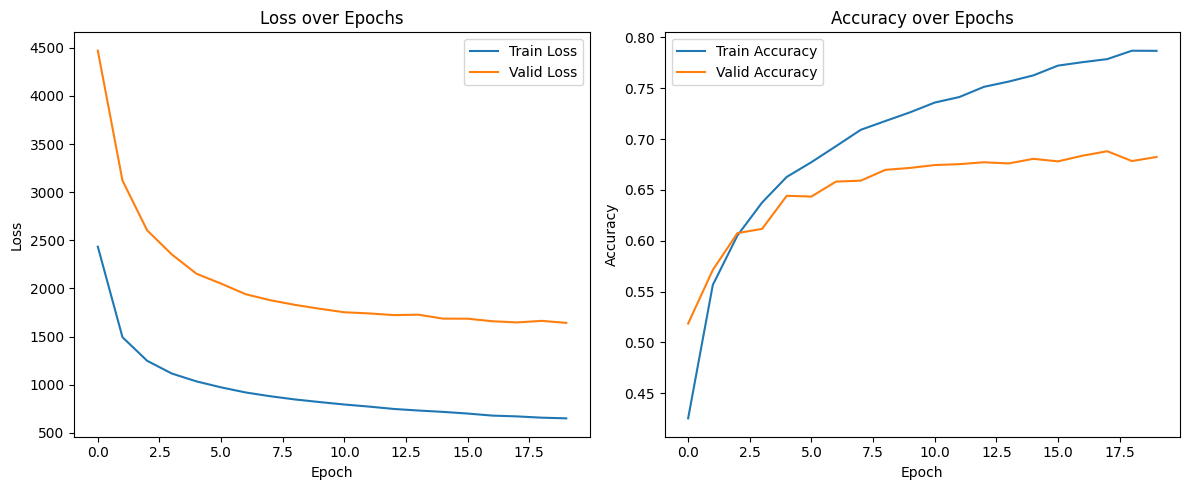

In [ ]:
torch.cuda.empty_cache()
run()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DeterministicCNN(nn.Module):
    def __init__(self):
        super(DeterministicCNN, self).__init__()

        # Capas convolucionales deterministas
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)

        # Capas densas deterministas
        self.fc1 = nn.Linear(16 * 8 * 8, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 10)  # Salida de 10 clases

        self.pool = nn.MaxPool2d(2, 2)
        self.num_classes = 10

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(-1, 16 * 8 * 8)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
def train_deterministic_model(net, optimizer, criterion, trainloader):
    """
    Entrena una red neuronal determinista.

    Parámetros:
      - net: modelo determinista (como DeterministicCNN)
      - optimizer: optimizador (por ejemplo, Adam)
      - criterion: función de pérdida (por ejemplo, nn.CrossEntropyLoss)
      - trainloader: DataLoader de entrenamiento

    Devuelve:
      - pérdida media del entrenamiento y exactitud media.
    """
    net.train()
    training_loss = 0.0
    accs = []

    for inputs, labels in trainloader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)  # forward normal
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        training_loss += loss.item()
        accs.append(acc(outputs, labels))  # usa tu función acc para accuracy

        torch.cuda.empty_cache()

    return (
        training_loss / len(trainloader),
        np.mean([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in accs])
    )



In [ ]:
def validate_deterministic_model(net, criterion, validloader):
    """
    Valida un modelo determinista en un conjunto de validación.

    Parámetros:
      - net: modelo determinista
      - criterion: función de pérdida (ej. nn.CrossEntropyLoss)
      - validloader: DataLoader de validación

    Devuelve:
      - pérdida media de validación y exactitud media.
    """
    net.eval()
    valid_loss = 0.0
    accs = []

    with torch.no_grad():
        for inputs, labels in validloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)  # forward determinista
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            accs.append(acc(outputs, labels))

    return (
        valid_loss / len(validloader),
        np.mean([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in accs])
    )


In [ ]:

def run_deterministic():
    n_epochs = 20
    patience = 5
    patience_counter = 0

    net = DeterministicCNN().to(device)
    ckpt_name = 'model_deterministic.weights.h5'

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
    valid_loss_max = np.inf

    # Inicializar history
    history = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }

    for epoch in range(n_epochs):
        train_loss, train_acc = train_deterministic_model(net, optimizer, criterion, filtered_train_loader)
        valid_loss, valid_acc = validate_deterministic_model(net, criterion, filtered_test_loader)

        # Guardar en history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["valid_loss"].append(valid_loss)
        history["valid_acc"].append(valid_acc)

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tTest Loss: {:.4f} \tTest Accuracy: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc))

        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'No improvement. Early stopping patience: {patience_counter}/{patience}')
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Plot resultados
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label='Train Loss')
    plt.plot(history["valid_loss"], label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label='Train Accuracy')
    plt.plot(history["valid_acc"], label='Valid Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch: 0 	Training Loss: 1.5349 	Training Accuracy: 0.4244 	Test Loss: 1.2924 	Test Accuracy: 0.5255
Validation loss decreased (inf --> 1.292363).  Saving model ...
Epoch: 1 	Training Loss: 1.1555 	Training Accuracy: 0.5776 	Test Loss: 1.1117 	Test Accuracy: 0.5937
Validation loss decreased (1.292363 --> 1.111690).  Saving model ...
Epoch: 2 	Training Loss: 1.0112 	Training Accuracy: 0.6350 	Test Loss: 1.0262 	Test Accuracy: 0.6333
Validation loss decreased (1.111690 --> 1.026197).  Saving model ...
Epoch: 3 	Training Loss: 0.9184 	Training Accuracy: 0.6712 	Test Loss: 0.9947 	Test Accuracy: 0.6478
Validation loss decreased (1.026197 --> 0.994742).  Saving model ...
Epoch: 4 	Training Loss: 0.8507 	Training Accuracy: 0.6961 	Test Loss: 0.9534 	Test Accuracy: 0.6636
Validation loss decreased (0.994742 --> 0.953375).  Saving model ...
Epoch: 5 	Training Loss: 0.8015 	Training Accuracy: 0.7130 	Test Loss: 1.0139 	Test Accuracy: 0.6425
No improvement. Early stopping patience: 1/5
Epoch: 6 

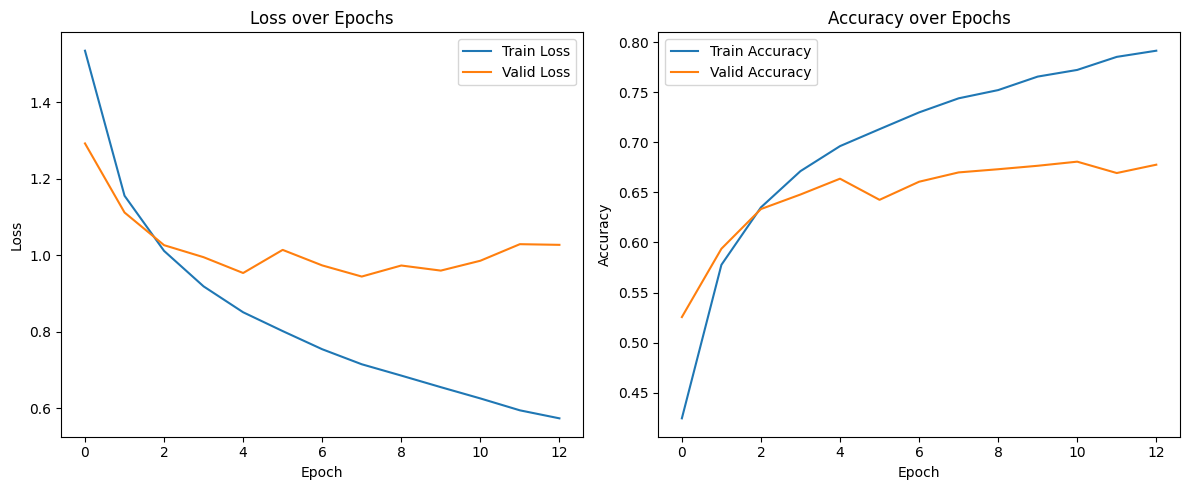

In [ ]:
run_deterministic()

In [ ]:
model_nobay = DeterministicCNN().to(device)

In [ ]:
model_nobay.load_state_dict(torch.load('/kaggle/input/pesoskl/model_deterministic.weights.h5'))

# 3. Poner el modelo en modo evaluación si lo vas a usar para inferencia
model_nobay.eval()

<ipython-input-47-4cf375eb89f0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_nobay.load_state_dict(torch.load('/kaggle/input/pesoskl/model_deterministic.weights.h5

DeterministicCNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
model_bay=BayesianCNN().to(device)
model_bay.load_state_dict(torch.load('/kaggle/input/pesoskl/model_bbb_256_512.weights.h5'))

# 3. Poner el modelo en modo evaluación si lo vas a usar para inferencia
model_bay.eval()

<ipython-input-48-8579af298eb8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_bay.load_state_dict(torch.load('/kaggle/input/pesoskl/model_bbb_256_512.weights.h5'))


BayesianCNN(
  (conv1): BBBConv2d()
  (conv2): BBBConv2d()
  (conv3): BBBConv2d()
  (conv4): BBBConv2d()
  (fc1): BBBDenseLayer()
  (fc2): BBBDenseLayer()
  (fc3): BBBDenseLayer()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

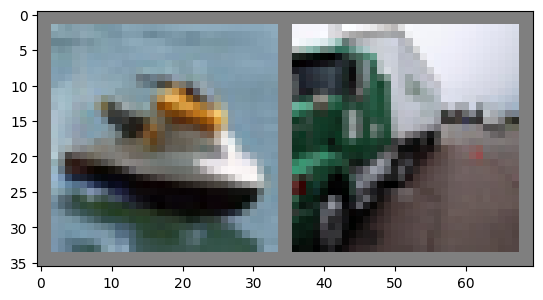

Conocida: ship | Desconocida: truck


In [ ]:
import random

# Elegir imágenes
def get_random_sample(dataset, label_to_select):
    indices = [i for i, (_, label) in enumerate(dataset) if label == label_to_select]
    idx = random.choice(indices)
    return dataset[idx][0].unsqueeze(0), label_to_select  # imagen y su clase real

# Clase desconocida
x_unk, y_unk = get_random_sample(test_dataset, excluded_class_idx)
# Clase conocida
x_known, y_known = get_random_sample(filtered_test_dataset, random.randint(0, excluded_class_idx - 1))

x_unk, x_known = x_unk.to(device), x_known.to(device)

# 2. Visualización de imágenes
imshow(torchvision.utils.make_grid(torch.cat([x_known.cpu(), x_unk.cpu()])))
print("Conocida:", classes[y_known], "| Desconocida:", classes[y_unk])


In [ ]:
def predict_deterministic(model, x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    return probs

probs_known_det = predict_deterministic(model_nobay, x_known)
probs_unk_det = predict_deterministic(model_nobay, x_unk)


In [ ]:
def predict_bayesian(model, x, num_samples=50):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for _ in range(num_samples):
            logits = model(x)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
            all_probs.append(probs)
    return np.array(all_probs)  # (num_samples, num_classes)

probs_known_bayes = predict_bayesian(model_bay, x_known)
probs_unk_bayes = predict_bayesian(model_bay, x_unk)

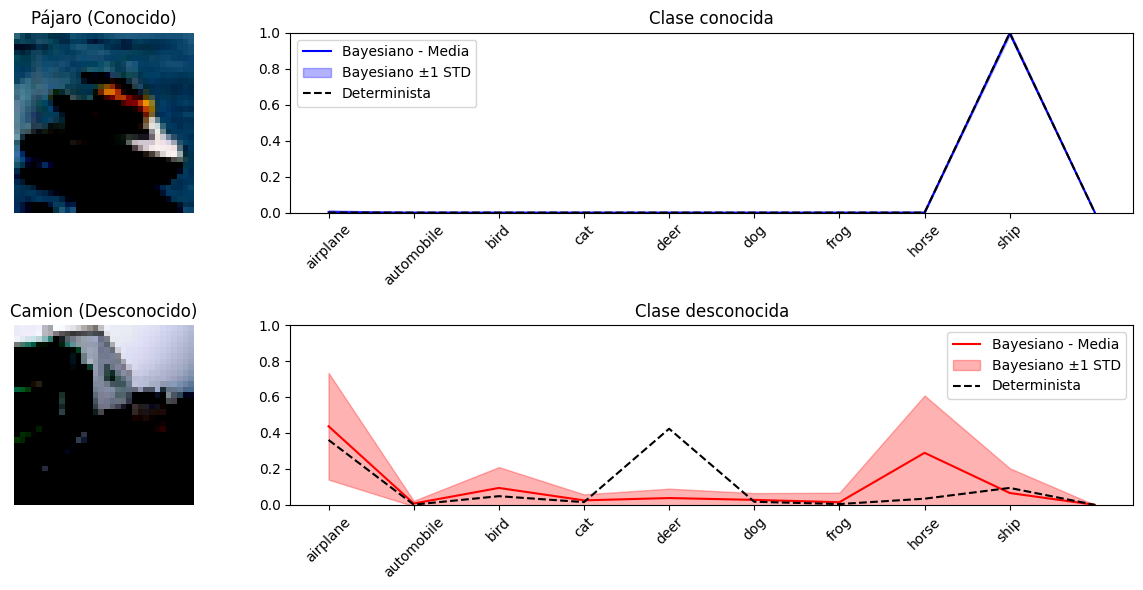

In [ ]:
import torchvision.transforms as T

def show_image(ax, tensor_image, title=""):
    img = tensor_image.squeeze().cpu()
    if img.shape[0] == 3:  # RGB
        img = img.permute(1, 2, 0)
    ax.imshow(img.numpy())
    ax.axis("off")
    ax.set_title(title)

def plot_comparison(ax, bayes_samples, det_probs, title, color, labels):
    bayes_samples = np.array(bayes_samples)
    mean_probs = bayes_samples.mean(axis=0)
    std_probs = bayes_samples.std(axis=0)

    # Bayesiano
    ax.plot(mean_probs, color=color, label="Bayesiano - Media")
    ax.fill_between(range(len(mean_probs)),
                    mean_probs - std_probs,
                    mean_probs + std_probs,
                    color=color, alpha=0.3, label="Bayesiano ±1 STD")

    # Determinista
    ax.plot(det_probs, color="black", linestyle="--", label="Determinista")

    ax.set_title(title)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_ylim(0, 1)
    ax.legend()



fig, axs = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 3]})


show_image(axs[0, 0], x_known, "Pájaro (Conocido)")
plot_comparison(axs[0, 1], probs_known_bayes, probs_known_det, "Clase conocida", "blue", labels)


show_image(axs[1, 0], x_unk, "Camion (Desconocido)")
plot_comparison(axs[1, 1], probs_unk_bayes, probs_unk_det, "Clase desconocida", "red", labels)

plt.tight_layout()
plt.show()


In [ ]:
def plot_bayesian_scatter(ax, bayes_samples, labels, title, color):
    bayes_samples = np.array(bayes_samples)
    pred_classes = np.argmax(bayes_samples, axis=1)

    # Eje X: clase predicha, Eje Y: sample index (con ruido para dispersión)
    x = pred_classes
    y = np.arange(len(pred_classes)) + np.random.uniform(-0.3, 0.3, size=len(pred_classes))

    ax.scatter(x, y, c=color, alpha=0.6)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_xlabel("Clases predichas")
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)


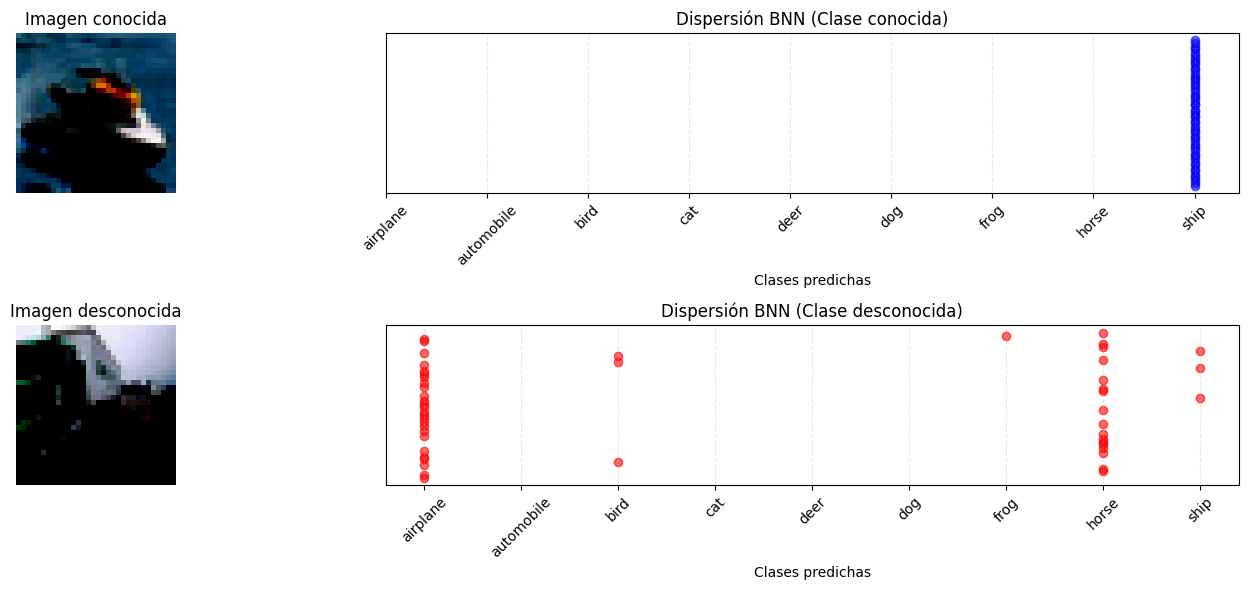

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 6))

show_image(axs[0, 0], x_known, "Imagen conocida")
plot_bayesian_scatter(axs[0, 1], probs_known_bayes, labels, "Dispersión BNN (Clase conocida)", "blue")


show_image(axs[1, 0], x_unk, "Imagen desconocida")
plot_bayesian_scatter(axs[1, 1], probs_unk_bayes, labels, "Dispersión BNN (Clase desconocida)", "red")

plt.tight_layout()
plt.show()


In [ ]:
temperatures = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2]
results = []  # (T, val_loss, val_acc)

In [ ]:
def validate_model(net, criterion, validloader, num_ens=1, epoch=None, num_epochs=None, beta=0.0001):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()  # Esto es intencional si estás usando MC dropout o redes bayesianas con sampling
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.shape[0]
        outputs = torch.zeros(batch_size, net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out = net(inputs)  # se espera que devuelva solo logits
            _kl = net.calculate_kl()
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = logmeanexp(outputs, dim=2)

        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(acc(log_outputs, labels))
        torch.cuda.empty_cache()

    return valid_loss / len(validloader), np.mean([a.detach().cpu().numpy() if isinstance(a, torch.Tensor) else a for a in accs])


In [ ]:
for T in temperatures:
    beta = T
    criterion = ELBO(len(filtered_test_loader)).to(device)
    valid_loss, valid_acc = validate_model(model_bay, criterion, filtered_test_loader, num_ens=5, beta=beta)
    results.append((T, valid_loss, valid_acc))
    print(f"T = {T:.2f} -> Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}")

RuntimeError: DataLoader worker (pid(s) 107, 108, 109, 110) exited unexpectedly

In [ ]:
T_vals = [r[0] for r in results]
val_losses = [r[1] for r in results]
val_accs = [r[2] for r in results]

plt.figure(figsize=(10, 5))

# Accuracy vs Temperature
plt.subplot(1, 2, 1)
plt.plot(T_vals, val_accs, marker='o', linestyle='-', color='green')
plt.xlabel('Temperature (T)')
plt.ylabel('Validation Accuracy')
plt.title('Cold Posterior Effect: Accuracy vs Temperature')
plt.grid(True)

# Loss vs Temperature
plt.subplot(1, 2, 2)
plt.plot(T_vals, val_losses, marker='o', linestyle='-', color='red')
plt.xlabel('Temperature (T)')
plt.ylabel('Validation Loss')
plt.title('Cold Posterior Effect: Loss vs Temperature')
plt.grid(True)

plt.tight_layout()
plt.show()